[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module5_Files/EDA_ML_Storms.ipynb)

#EDA and ML for Storm Classification Data
**Dr. Dave Wanik - University of Connecticut**

*Thanks to my former student Vineela Datla for sharing data and ideas for this example!*

In this project, the goal is to be able to classify text. The data is from the NOAA website that has descriptive data about the storm events.
https://www1.ncdc.noaa.gov/pub/data/swdi/stormevents/csvfiles/

This example can generalize to ANY text classification problem and EDA you want to solve - so long as your data is stored in a .csv, you can use most of this code directly with only light editing.

In [ ]:
# import modules
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# need to add nltk imports up here
# link: https://www.nltk.org/
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

We read in the data and see this has a traditional database output, with some limited numeric columns. The best data is all the way to the right (comment fields!)

In the old days, I would've deleted these things since I had no use for them - but now, with all of the open-source software available, you can really bring that data to life and 1) not only explore it but 2) build models with it! Let's get to work.

In [ ]:
# we will read the file directly from this link
# url = "https://drive.google.com/uc?export=download&id=1jvIwUFVMZE7bQwGQeiu1yT6CSIdieu6_"

# Link to the data file on Github
url = "https://raw.githubusercontent.com/drdave-teaching/OPIM5509Files/refs/heads/main/OPIM5509_Module5_Files/StormEvents_2019.csv"

dataframe = pd.read_csv(url, header = 0) # this means there is a header in the first row
storm_df = pd.DataFrame(dataframe)
print(storm_df.shape) # woah! 60K rows and 28 columns, very nice.
storm_df.head()

(61324, 28)


,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,137295,824116,TEXAS,48,2019,May,Flash Flood,BEXAR,5/9/2019 15:54,CST-6,...,N,LEON SPGS,NNE,SAN GERONIMO,29.7898,-98.6406,29.7158,-98.7744,Thunderstorms developed along a cold front as ...,Thunderstorms produced heavy rain that led to ...
1,140217,843354,MINNESOTA,27,2019,July,Thunderstorm Wind,PINE,7/15/2019 16:40,CST-6,...,E,ROCK CREEK,E,ROCK CREEK,45.7700,-92.8700,45.7700,-92.8700,An area of low pressure over southern Manitoba...,A 14-inch tree fell due to the winds and damag...
2,142648,861581,TEXAS,48,2019,October,Thunderstorm Wind,VAN ZANDT,10/20/2019 22:23,CST-6,...,N,EDGEWOOD,N,EDGEWOOD,32.7100,-95.8800,32.7100,-95.8800,Thunderstorms erupted across the DFW Metroplex...,A trained spotter measured a wind gust of 67 M...
3,142648,861584,TEXAS,48,2019,October,Thunderstorm Wind,TARRANT,10/20/2019 23:12,CST-6,...,WSW,AZLE,WSW,AZLE,32.8700,-97.6100,32.8700,-97.6100,Thunderstorms erupted across the DFW Metroplex...,The local police department reported a wind gu...
4,142648,861582,TEXAS,48,2019,October,Thunderstorm Wind,PALO PINTO,10/20/2019 22:36,CST-6,...,N,MINERAL WELLS,N,MINERAL WELLS,32.8000,-98.1000,32.8000,-98.1000,Thunderstorms erupted across the DFW Metroplex...,A wind gust of 75 MPH was measured by the Auto...


Let's look at a sample text examples. There is a detailed column (EPISODE_NARRATIVE) and a more concise column (EVENT_NARRATIVE).

In [ ]:
# there's a more detailed column called "EPISODE_NARRATIVE"
print(storm_df['EPISODE_NARRATIVE'][0])
print(storm_df['EPISODE_NARRATIVE'][1])
print(storm_df['EPISODE_NARRATIVE'][2])

Thunderstorms developed along a cold front as it moved through South Central Texas. Some of these storms produced large hail, damaging wind gusts, and heavy rain that led to flash flooding.
An area of low pressure over southern Manitoba the morning of the 15th moved to near southern Hudson Bay by the morning of the 16th. A cold front associated with this low moved across the Northland during the afternoon and evening hours of the 15th. A warm front had moved through on the previous day brought a warm and unstable airmass in its wake. The cold front then worked with this airmass to create severe storms from northeast Minnesota into northwest Wisconsin and western Lake Superior. Damaging winds accounted for most of the reports with these storms, although there was some marginally severe hail as well. Most of the damage was to trees, but some property damage to pontoon boats and a home also occurred.
Thunderstorms erupted across the DFW Metroplex as a strong upper level system and a cold 

In [ ]:
# first observations from storm_df['EVENT_NARRATIVE']
print(storm_df['EVENT_NARRATIVE'][0])
print(storm_df['EVENT_NARRATIVE'][1])
print(storm_df['EVENT_NARRATIVE'][2])

Thunderstorms produced heavy rain that led to flash flooding. Multiple low water crossings were closed in northwestern Bexar County.
A 14-inch tree fell due to the winds and damaged a garage, vehicle and a light pole.
A trained spotter measured a wind gust of 67 MPH approximately one mile north of the city of Edgewood, TX.


As we are trying to classify event type based on the narrative, lets get rid of the rows where the data narrative is not available

In [ ]:
# Checking for null values in event narrative column
storm_df.info()

# the data is MOSTLY good but has some nulls, so we drop it.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61324 entries, 0 to 61323
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EPISODE_ID         61324 non-null  int64  
 1   EVENT_ID           61324 non-null  int64  
 2   STATE              61324 non-null  object 
 3   STATE_FIPS         61324 non-null  int64  
 4   YEAR               61324 non-null  int64  
 5   MONTH_NAME         61324 non-null  object 
 6   EVENT_TYPE         61324 non-null  object 
 7   CZ_NAME            61324 non-null  object 
 8   BEGIN_DATE_TIME    61324 non-null  object 
 9   CZ_TIMEZONE        61324 non-null  object 
 10  END_DATE_TIME      61324 non-null  object 
 11  INJURIES_DIRECT    61324 non-null  int64  
 12  INJURIES_INDIRECT  61324 non-null  int64  
 13  DEATHS_DIRECT      61324 non-null  int64  
 14  DEATHS_INDIRECT    61324 non-null  int64  
 15  DAMAGE_PROPERTY    49501 non-null  object 
 16  DAMAGE_CROPS       499

In [ ]:
# Dropping rows where event narrative is empty...
event_df = storm_df.dropna(subset=['EVENT_NARRATIVE'])
print(event_df.shape) # now we have 48K rows
event_df.head()

(48324, 28)


,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,137295,824116,TEXAS,48,2019,May,Flash Flood,BEXAR,5/9/2019 15:54,CST-6,...,N,LEON SPGS,NNE,SAN GERONIMO,29.7898,-98.6406,29.7158,-98.7744,Thunderstorms developed along a cold front as ...,Thunderstorms produced heavy rain that led to ...
1,140217,843354,MINNESOTA,27,2019,July,Thunderstorm Wind,PINE,7/15/2019 16:40,CST-6,...,E,ROCK CREEK,E,ROCK CREEK,45.7700,-92.8700,45.7700,-92.8700,An area of low pressure over southern Manitoba...,A 14-inch tree fell due to the winds and damag...
2,142648,861581,TEXAS,48,2019,October,Thunderstorm Wind,VAN ZANDT,10/20/2019 22:23,CST-6,...,N,EDGEWOOD,N,EDGEWOOD,32.7100,-95.8800,32.7100,-95.8800,Thunderstorms erupted across the DFW Metroplex...,A trained spotter measured a wind gust of 67 M...
3,142648,861584,TEXAS,48,2019,October,Thunderstorm Wind,TARRANT,10/20/2019 23:12,CST-6,...,WSW,AZLE,WSW,AZLE,32.8700,-97.6100,32.8700,-97.6100,Thunderstorms erupted across the DFW Metroplex...,The local police department reported a wind gu...
4,142648,861582,TEXAS,48,2019,October,Thunderstorm Wind,PALO PINTO,10/20/2019 22:36,CST-6,...,N,MINERAL WELLS,N,MINERAL WELLS,32.8000,-98.1000,32.8000,-98.1000,Thunderstorms erupted across the DFW Metroplex...,A wind gust of 75 MPH was measured by the Auto...


We can make a nice barplot of the different storm types.

<ipython-input-7-48570af8b35d>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


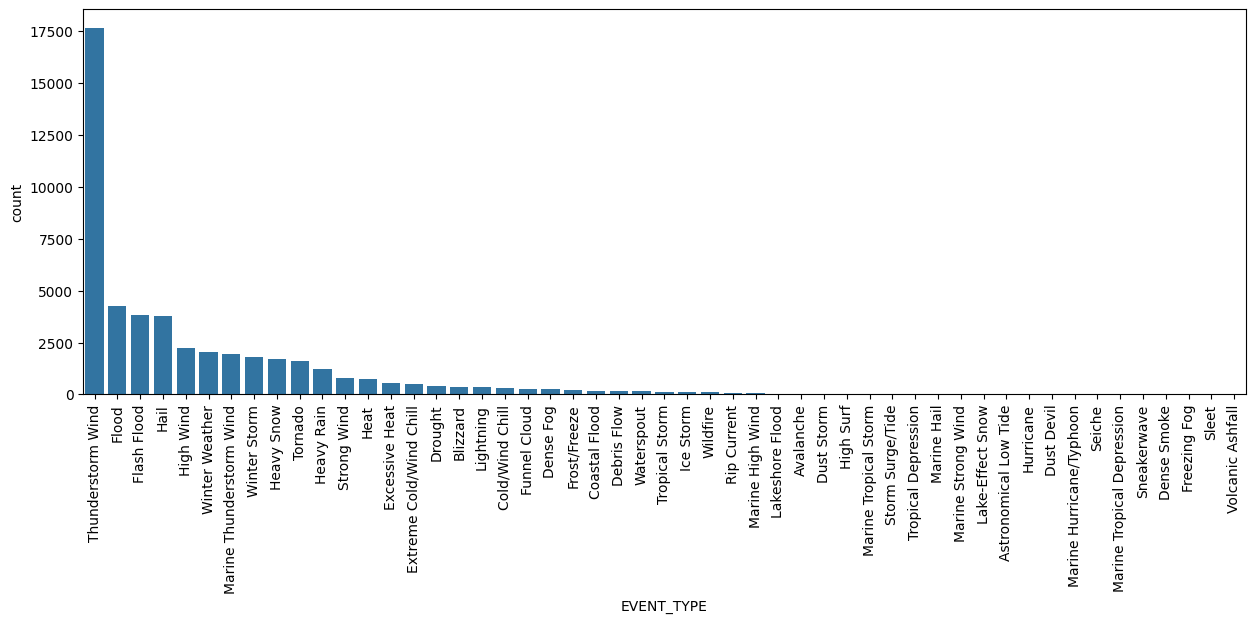

In [ ]:
# to sort by frequency...
# link: https://stackoverflow.com/questions/46623583/seaborn-countplot-order-categories-by-count

plt.figure(figsize=(15,5))
ax = sns.countplot(x="EVENT_TYPE", data=event_df,
                   order = event_df['EVENT_TYPE'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
# subset those storms that have at least 300 observations
final_df = event_df[event_df.groupby("EVENT_TYPE")["EVENT_ID"].transform('count')>300]
final_df.groupby("EVENT_TYPE")["EVENT_ID"].count()

,EVENT_ID
EVENT_TYPE,
Blizzard,345
Cold/Wind Chill,308
Drought,421
Excessive Heat,553
Extreme Cold/Wind Chill,526
Flash Flood,3851
Flood,4253
Hail,3783
Heat,733


<ipython-input-9-135ac6864537>:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


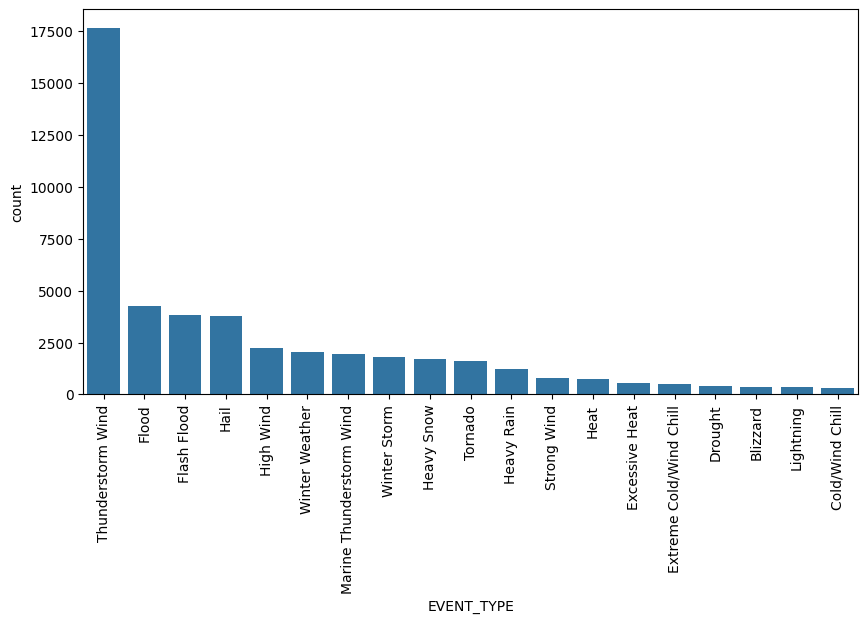

In [ ]:
# show a plot of the different categories (count of obserations)
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
ax = sns.countplot(x="EVENT_TYPE", data=final_df,
                   order = final_df['EVENT_TYPE'].value_counts().index)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

Remember, we've made three different versions of the data now:
* storm_df (original data)
* event_df (has only complete rows for text data)
* final_df (contains storms with as least 300 counts)

# Exploring the text data
Let's compare hail storms and flash floods and see what's going on.

# Subset Hail data
First things first - let's take a peak at just the hail storms.

In [ ]:
hail_df = final_df[final_df['EVENT_TYPE']=='Hail']
hail_df.info() # looks like there are 3783 hail storms

<class 'pandas.core.frame.DataFrame'>
Index: 3783 entries, 6 to 61237
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EPISODE_ID         3783 non-null   int64  
 1   EVENT_ID           3783 non-null   int64  
 2   STATE              3783 non-null   object 
 3   STATE_FIPS         3783 non-null   int64  
 4   YEAR               3783 non-null   int64  
 5   MONTH_NAME         3783 non-null   object 
 6   EVENT_TYPE         3783 non-null   object 
 7   CZ_NAME            3783 non-null   object 
 8   BEGIN_DATE_TIME    3783 non-null   object 
 9   CZ_TIMEZONE        3783 non-null   object 
 10  END_DATE_TIME      3783 non-null   object 
 11  INJURIES_DIRECT    3783 non-null   int64  
 12  INJURIES_INDIRECT  3783 non-null   int64  
 13  DEATHS_DIRECT      3783 non-null   int64  
 14  DEATHS_INDIRECT    3783 non-null   int64  
 15  DAMAGE_PROPERTY    2796 non-null   object 
 16  DAMAGE_CROPS       2862 non-

# Traditional EDA on the Hail Data
How many injuries and deaths were there? What was the damage to property and crops? The injury and death data is int64 (numeric), but we will need to wrangle the property and crop data (it's stored as a string, because there a K and M at the end of the number!)

### Injuries and Deaths

In [ ]:
# overview of injuries per storm
hail_df['INJURIES_DIRECT'].value_counts() # not too many

,count
INJURIES_DIRECT,
0,3782
1,1


In [ ]:
# overview of injuries per storm
hail_df['INJURIES_INDIRECT'].value_counts() # not too many

,count
INJURIES_INDIRECT,
0,3782
3,1


In [ ]:
# overview of deaths  per storm
hail_df['DEATHS_DIRECT'].value_counts() # no deaths!

,count
DEATHS_DIRECT,
0,3783


In [ ]:
# overview of injuries per storm
hail_df['DEATHS_INDIRECT'].value_counts() # still no deaths!

,count
DEATHS_INDIRECT,
0,3783


### Property and Crop Damage
Are these storms destructive?

In [ ]:
hail_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3783 entries, 6 to 61237
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EPISODE_ID         3783 non-null   int64  
 1   EVENT_ID           3783 non-null   int64  
 2   STATE              3783 non-null   object 
 3   STATE_FIPS         3783 non-null   int64  
 4   YEAR               3783 non-null   int64  
 5   MONTH_NAME         3783 non-null   object 
 6   EVENT_TYPE         3783 non-null   object 
 7   CZ_NAME            3783 non-null   object 
 8   BEGIN_DATE_TIME    3783 non-null   object 
 9   CZ_TIMEZONE        3783 non-null   object 
 10  END_DATE_TIME      3783 non-null   object 
 11  INJURIES_DIRECT    3783 non-null   int64  
 12  INJURIES_INDIRECT  3783 non-null   int64  
 13  DEATHS_DIRECT      3783 non-null   int64  
 14  DEATHS_INDIRECT    3783 non-null   int64  
 15  DAMAGE_PROPERTY    2796 non-null   object 
 16  DAMAGE_CROPS       2862 non-

In [ ]:
# any property damage?
# whoa, this doesn't look right... maybe need to convert to numeric
hail_df[['DAMAGE_CROPS', 'DAMAGE_PROPERTY']].describe()

,DAMAGE_CROPS,DAMAGE_PROPERTY
count,2862,2796
unique,23,54
top,0.00K,0.00K
freq,2772,2483


In [ ]:
# what is going on with DAMAGE_PROPERTY and DAMAGE_CROPS?
hail_df[['DAMAGE_PROPERTY', 'DAMAGE_CROPS']].head()

,DAMAGE_PROPERTY,DAMAGE_CROPS
6,0.00K,0.00K
20,0.00K,0.00K
21,0.00K,0.00K
31,0.00K,0.00K
42,0.00K,0.00K


In [ ]:
# here is how to convert the field
# you replace K and/or M with just an empty strings
# then you can multiply by 10^3 for K, and 10^6 for M
# hacked this example: https://stackoverflow.com/questions/39684548/convert-the-string-2-90k-to-2900-or-5-2m-to-5200000-in-pandas-dataframe
hail_df['DAMAGE_CROPS'] = (hail_df['DAMAGE_CROPS'].replace(r'[KM]+$', '', regex=True).astype(float) * \
              hail_df['DAMAGE_CROPS'].str.extract(r'[\d\.]+([KM]+)', expand=False)
                .fillna(1)
                .replace(['K','M'], [10**3, 10**6]).astype(int))
hail_df['DAMAGE_CROPS'].describe()

<ipython-input-18-e5ab74b35365>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(['K','M'], [10**3, 10**6]).astype(int))
<ipython-input-18-e5ab74b35365>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hail_df['DAMAGE_CROPS'] = (hail_df['DAMAGE_CROPS'].replace(r'[KM]+$', '', regex=True).astype(float) * \


,DAMAGE_CROPS
count,2.862000e+03
mean,6.382855e+03
std,1.166219e+05
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,5.000000e+06


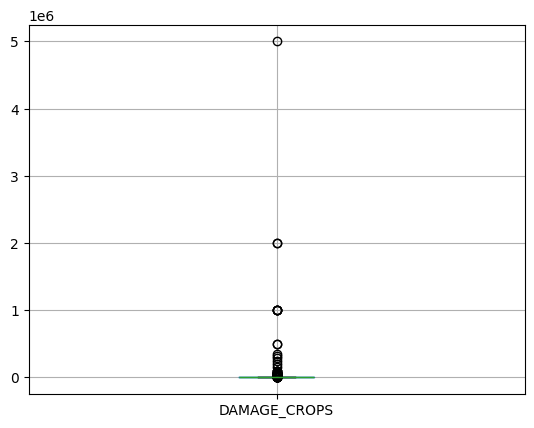

In [ ]:
# visualize it! not great a plot... what can we do to inspect tails?
hail_df.boxplot(['DAMAGE_CROPS'])
plt.show()

In [ ]:
# one more table - better story!
hail_df['DAMAGE_CROPS'].quantile([0.8, 0.9, 0.95, 0.975, 0.99, 0.999, 1])

# we are looking at the tail, and we see that in:
# 97.5% of cases, there is only 100 dollars of damage or less
# but there is a 1% chance that there will be 50K or more in damage to crops!
# and there is a 0.1% chance that there will be 1M damage or more to crops!

# you have to be curious about this stuff and dig deep, especially when the your
# visualization is not as useful as you would've hoped

# the tails/extremes are the most interesting!

,DAMAGE_CROPS
0.800,0.0
0.900,0.0
0.950,0.0
0.975,100.0
0.990,50000.0
0.999,1139000.0
1.000,5000000.0


# Dig into the Event Narrative
We can build models for classification based on Episode Narrative or Event Narrative! Let's explore!!!

In [ ]:
# reset the index just so it looks nice
hail_df.reset_index(inplace=True)
hail_df.head()

,index,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,6,141212,848333,VERMONT,50,2019,September,Hail,WINDSOR,9/4/2019 12:29,...,W,LUDLOW,W,LUDLOW,43.40,-72.72,43.40,-72.72,A strong mid-level disturbance and cold front ...,Quarter size hail reported at Okemo Ski resort.
1,20,139926,844159,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:37,...,ENE,FROID,ENE,FROID,48.39,-104.26,48.39,-104.26,Plentiful surface moisture from the southeast ...,Trained spotter reported hail up to the size o...
2,21,139926,844160,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:50,...,ENE,FROID,ENE,FROID,48.39,-104.29,48.39,-104.29,Plentiful surface moisture from the southeast ...,"Public reported, via social media, quarter siz..."
3,31,139926,844158,MONTANA,30,2019,September,Hail,SHERIDAN,9/2/2019 7:27,...,WSW,PLENTYWOOD,WSW,PLENTYWOOD,48.72,-104.74,48.72,-104.74,Plentiful surface moisture from the southeast ...,Public reported quarter size hail.
4,42,141962,852318,CONNECTICUT,9,2019,September,Hail,HARTFORD,9/4/2019 16:10,...,N,ENFIELD,N,ENFIELD,41.97,-72.57,41.97,-72.57,A cold front pushed through southern New Engla...,Dime size hail was reported in Enfield.


In [ ]:
# get rid of the original index column
del hail_df['index']
print(hail_df.shape)
hail_df.head()

(3783, 28)


,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,141212,848333,VERMONT,50,2019,September,Hail,WINDSOR,9/4/2019 12:29,EST-5,...,W,LUDLOW,W,LUDLOW,43.40,-72.72,43.40,-72.72,A strong mid-level disturbance and cold front ...,Quarter size hail reported at Okemo Ski resort.
1,139926,844159,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:37,MST-7,...,ENE,FROID,ENE,FROID,48.39,-104.26,48.39,-104.26,Plentiful surface moisture from the southeast ...,Trained spotter reported hail up to the size o...
2,139926,844160,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:50,MST-7,...,ENE,FROID,ENE,FROID,48.39,-104.29,48.39,-104.29,Plentiful surface moisture from the southeast ...,"Public reported, via social media, quarter siz..."
3,139926,844158,MONTANA,30,2019,September,Hail,SHERIDAN,9/2/2019 7:27,MST-7,...,WSW,PLENTYWOOD,WSW,PLENTYWOOD,48.72,-104.74,48.72,-104.74,Plentiful surface moisture from the southeast ...,Public reported quarter size hail.
4,141962,852318,CONNECTICUT,9,2019,September,Hail,HARTFORD,9/4/2019 16:10,EST-5,...,N,ENFIELD,N,ENFIELD,41.97,-72.57,41.97,-72.57,A cold front pushed through southern New Engla...,Dime size hail was reported in Enfield.


### Lowercase
There is no difference between the words "HAIL", "Hail" and "hail"...
To make our analysis more meaningful, we make all of these words lowercase.

In [ ]:
# before we get started, here are the first three rows
print(hail_df['EVENT_NARRATIVE'][0])
print(hail_df['EVENT_NARRATIVE'][1])
print(hail_df['EVENT_NARRATIVE'][2])

Quarter size hail reported at Okemo Ski resort.
Trained spotter reported hail up to the size of quarters, along with heavy rain and standing water in their yard.
Public reported, via social media, quarter size hail.


In [ ]:
# make everything lowercase
hail_df['EVENT_NARRATIVE'] = hail_df['EVENT_NARRATIVE'].str.lower()
hail_df.head()

<ipython-input-24-14f402e1702f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hail_df['EVENT_NARRATIVE'] = hail_df['EVENT_NARRATIVE'].str.lower()


,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,141212,848333,VERMONT,50,2019,September,Hail,WINDSOR,9/4/2019 12:29,EST-5,...,W,LUDLOW,W,LUDLOW,43.40,-72.72,43.40,-72.72,A strong mid-level disturbance and cold front ...,quarter size hail reported at okemo ski resort.
1,139926,844159,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:37,MST-7,...,ENE,FROID,ENE,FROID,48.39,-104.26,48.39,-104.26,Plentiful surface moisture from the southeast ...,trained spotter reported hail up to the size o...
2,139926,844160,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:50,MST-7,...,ENE,FROID,ENE,FROID,48.39,-104.29,48.39,-104.29,Plentiful surface moisture from the southeast ...,"public reported, via social media, quarter siz..."
3,139926,844158,MONTANA,30,2019,September,Hail,SHERIDAN,9/2/2019 7:27,MST-7,...,WSW,PLENTYWOOD,WSW,PLENTYWOOD,48.72,-104.74,48.72,-104.74,Plentiful surface moisture from the southeast ...,public reported quarter size hail.
4,141962,852318,CONNECTICUT,9,2019,September,Hail,HARTFORD,9/4/2019 16:10,EST-5,...,N,ENFIELD,N,ENFIELD,41.97,-72.57,41.97,-72.57,A cold front pushed through southern New Engla...,dime size hail was reported in enfield.


In [ ]:
# here's an example of what we did
print(hail_df['EVENT_NARRATIVE'][0])
print(hail_df['EVENT_NARRATIVE'][1])
print(hail_df['EVENT_NARRATIVE'][2])

quarter size hail reported at okemo ski resort.
trained spotter reported hail up to the size of quarters, along with heavy rain and standing water in their yard.
public reported, via social media, quarter size hail.


### Strip funky characters (!,~-@$% etc)
Funky characters can be a pain - they make words appear to be unique (think of trouble with strings). Let's ditch 'em!

In [ ]:
# remove any funky characters with a blank
hail_df['EVENT_NARRATIVE'] = hail_df['EVENT_NARRATIVE'].str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()
hail_df.head()

<ipython-input-26-0fd74dea644e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hail_df['EVENT_NARRATIVE'] = hail_df['EVENT_NARRATIVE'].str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()


,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,141212,848333,VERMONT,50,2019,September,Hail,WINDSOR,9/4/2019 12:29,EST-5,...,W,LUDLOW,W,LUDLOW,43.40,-72.72,43.40,-72.72,A strong mid-level disturbance and cold front ...,quarter size hail reported at okemo ski resort.
1,139926,844159,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:37,MST-7,...,ENE,FROID,ENE,FROID,48.39,-104.26,48.39,-104.26,Plentiful surface moisture from the southeast ...,trained spotter reported hail up to the size o...
2,139926,844160,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:50,MST-7,...,ENE,FROID,ENE,FROID,48.39,-104.29,48.39,-104.29,Plentiful surface moisture from the southeast ...,"public reported, via social media, quarter siz..."
3,139926,844158,MONTANA,30,2019,September,Hail,SHERIDAN,9/2/2019 7:27,MST-7,...,WSW,PLENTYWOOD,WSW,PLENTYWOOD,48.72,-104.74,48.72,-104.74,Plentiful surface moisture from the southeast ...,public reported quarter size hail.
4,141962,852318,CONNECTICUT,9,2019,September,Hail,HARTFORD,9/4/2019 16:10,EST-5,...,N,ENFIELD,N,ENFIELD,41.97,-72.57,41.97,-72.57,A cold front pushed through southern New Engla...,dime size hail was reported in enfield.


In [ ]:
# let's see what we did, no commas or periods!!!
print(hail_df['EVENT_NARRATIVE'][0])
print(hail_df['EVENT_NARRATIVE'][1])
print(hail_df['EVENT_NARRATIVE'][2])

quarter size hail reported at okemo ski resort.
trained spotter reported hail up to the size of quarters, along with heavy rain and standing water in their yard.
public reported, via social media, quarter size hail.


### Stop words
'Stop words' are simply common words in the English language - they are not special and generally don't convey too much information. So it's best to get rid of them.

In [ ]:
# let's remove some of the stop words (see what happens if you comment this cell out)
# we can do better!
# define some stop words
import nltk
from nltk.corpus import stopwords


nltk.download('stopwords') # this makes sure these are downloaded if you haven't already!
print(stopwords.words('english'))

stop = stopwords.words('english') # see why it's important to turn everything lower case? all of your stopwords are!

[nltk_data] Downloading package stopwords to /root/nltk_data...


['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an', 'and', 'any', 'are', 'aren', "aren't", 'as', 'at', 'be', 'because', 'been', 'before', 'being', 'below', 'between', 'both', 'but', 'by', 'can', 'couldn', "couldn't", 'd', 'did', 'didn', "didn't", 'do', 'does', 'doesn', "doesn't", 'doing', 'don', "don't", 'down', 'during', 'each', 'few', 'for', 'from', 'further', 'had', 'hadn', "hadn't", 'has', 'hasn', "hasn't", 'have', 'haven', "haven't", 'having', 'he', "he'd", "he'll", 'her', 'here', 'hers', 'herself', "he's", 'him', 'himself', 'his', 'how', 'i', "i'd", 'if', "i'll", "i'm", 'in', 'into', 'is', 'isn', "isn't", 'it', "it'd", "it'll", "it's", 'its', 'itself', "i've", 'just', 'll', 'm', 'ma', 'me', 'mightn', "mightn't", 'more', 'most', 'mustn', "mustn't", 'my', 'myself', 'needn', "needn't", 'no', 'nor', 'not', 'now', 'o', 'of', 'off', 'on', 'once', 'only', 'or', 'other', 'our', 'ours', 'ourselves', 'out', 'over', 'own', 're', 's', 'same', 'shan', "shan't", 'she

[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# remove the stop words
# apply these stopwords to the data
# link: https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe/43407993

# this looks good!
# ' '. adds a nice space (try adding a 'D' instead of ' ' and see what happens!)
hail_df.head() # note how the stop words have been removed
hail_df["EVENT_NARRATIVE"] = hail_df['EVENT_NARRATIVE'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
hail_df.head()

<ipython-input-29-5dc8fa3a8d32>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hail_df["EVENT_NARRATIVE"] = hail_df['EVENT_NARRATIVE'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,141212,848333,VERMONT,50,2019,September,Hail,WINDSOR,9/4/2019 12:29,EST-5,...,W,LUDLOW,W,LUDLOW,43.40,-72.72,43.40,-72.72,A strong mid-level disturbance and cold front ...,quarter size hail reported okemo ski resort.
1,139926,844159,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:37,MST-7,...,ENE,FROID,ENE,FROID,48.39,-104.26,48.39,-104.26,Plentiful surface moisture from the southeast ...,"trained spotter reported hail size quarters, a..."
2,139926,844160,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:50,MST-7,...,ENE,FROID,ENE,FROID,48.39,-104.29,48.39,-104.29,Plentiful surface moisture from the southeast ...,"public reported, via social media, quarter siz..."
3,139926,844158,MONTANA,30,2019,September,Hail,SHERIDAN,9/2/2019 7:27,MST-7,...,WSW,PLENTYWOOD,WSW,PLENTYWOOD,48.72,-104.74,48.72,-104.74,Plentiful surface moisture from the southeast ...,public reported quarter size hail.
4,141962,852318,CONNECTICUT,9,2019,September,Hail,HARTFORD,9/4/2019 16:10,EST-5,...,N,ENFIELD,N,ENFIELD,41.97,-72.57,41.97,-72.57,A cold front pushed through southern New Engla...,dime size hail reported enfield.


In [ ]:
# let's see what we did, no commas or periods!!!
print(hail_df['EVENT_NARRATIVE'][0])
print(hail_df['EVENT_NARRATIVE'][1])
print(hail_df['EVENT_NARRATIVE'][2])

quarter size hail reported okemo ski resort.
trained spotter reported hail size quarters, along heavy rain standing water yard.
public reported, via social media, quarter size hail.


# Text EDA on the Hail Data

### Most common words
Word clouds and frequency tables/plots.

In [ ]:
# 1) what are the most common words in the EVENT_NARRATIVE? note that we are doing this before tokenizer
# you can also turn this into a bar plot!
myTable = hail_df['EVENT_NARRATIVE'].str.split(expand=True).stack().value_counts()
myTable[0:20] # too cool!

,count
hail,3146
size,1738
reported,1576
quarter,1025
sized,664
ball,507
report,434
near,425
spotter,399
hail.,388


In [ ]:
# and we can make a frequency plot
# we'll group, then convert to pandas DataFrame for easy plotting
x = hail_df['EVENT_NARRATIVE'].str.split(expand=True).stack().value_counts()
x = pd.DataFrame(x)
# reset the index
x.reset_index(inplace=True)
# rename the columns
x.rename(columns={x.columns[0]:'word', x.columns[1]:'frequency'}, inplace=True)
x.head()

,word,frequency
0,hail,3146
1,size,1738
2,reported,1576
3,quarter,1025
4,sized,664


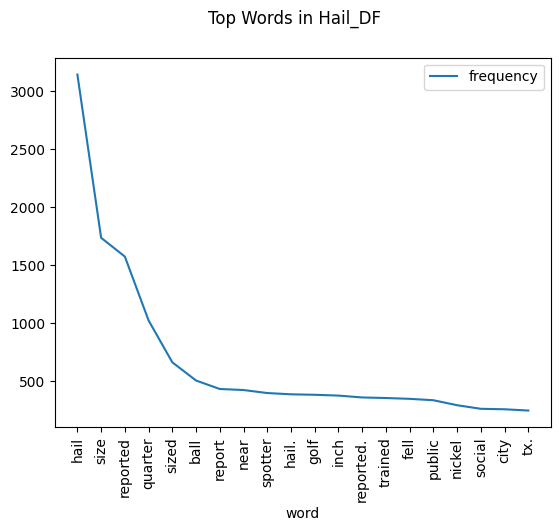

In [ ]:
# Frequency Distribution Plot
# look at first X words

# len(x) just the number of rows

x = x[0:20] # wanna play? change the 20 to 10 or 30 and see what happens...
            # you need to run the previous cell first
x.plot(x='word', y='frequency')
plt.xticks(np.arange(len(x)), x['word'], rotation=90)
plt.suptitle('Top Words in Hail_DF')
plt.show()


In [ ]:
# # if we wanted to, we could delete 'hail' so that the model isn't cheating!
# # to do this, we just need to append our stop words...

# # i will keep this commented out for now, but it's possible to do this and repeat the notebook!

# # not shown here, but like this
# # link: https://stackabuse.com/removing-stop-words-from-strings-in-python/#:~:text=Using%20Python's%20NLTK%20Library&text=NLTK%20supports%20stop%20word%20removal,stop%20words%20provided%20by%20NLTK.

# # import
# nltk.download('punkt')
# from nltk.tokenize import word_tokenize

# sw_list = ['hail']
# stop.extend(sw_list)

# text_tokens = word_tokenize(str(hail_df["EVENT_NARRATIVE"]))
# tokens_without_sw = [word for word in text_tokens if not word in stop]

# print(tokens_without_sw) # see, now hail is gone!!!
# # would the model do just as well without hail in the description?

### Word Cloud
Instead of just word frequency, you can get a nice graphic like this! Words that are most common are large. You can read more about customization here:
https://www.datacamp.com/community/tutorials/wordcloud-python

You can be creative here!!!

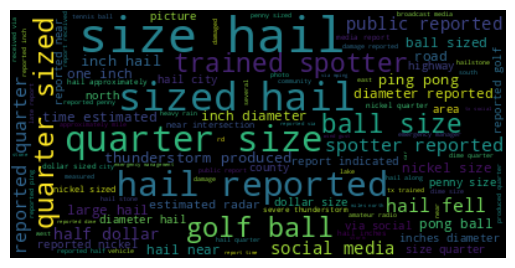

In [ ]:
# https://amueller.github.io/word_cloud/auto_examples/simple.html#sphx-glr-auto-examples-simple-py

from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(hail_df['EVENT_NARRATIVE']))

# # Display the generated image:
# # the matplotlib way:
# import matplotlib.pyplot as plt
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(' '.join(hail_df['EVENT_NARRATIVE']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

### Tokenizer
The tokenizer takes a given sentence and parses it into a list with individual words separated by a comma. This makes it easy for us to do some feature engineering later on in the notebook.

In [ ]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [ ]:
# tokenizer
# hello tokenizer! make this a list with individual entries/values
hail_df['EVENT_NARRATIVE'] = hail_df.apply(lambda row: nltk.word_tokenize(row['EVENT_NARRATIVE']), axis=1)
hail_df.head()
# could also have created a new column?
# link: https://stackoverflow.com/questions/33098040/how-to-use-word-tokenize-in-data-frame

<ipython-input-39-7ca07c269d2f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hail_df['EVENT_NARRATIVE'] = hail_df.apply(lambda row: nltk.word_tokenize(row['EVENT_NARRATIVE']), axis=1)


,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,141212,848333,VERMONT,50,2019,September,Hail,WINDSOR,9/4/2019 12:29,EST-5,...,W,LUDLOW,W,LUDLOW,43.40,-72.72,43.40,-72.72,A strong mid-level disturbance and cold front ...,"[quarter, size, hail, reported, okemo, ski, re..."
1,139926,844159,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:37,MST-7,...,ENE,FROID,ENE,FROID,48.39,-104.26,48.39,-104.26,Plentiful surface moisture from the southeast ...,"[trained, spotter, reported, hail, size, quart..."
2,139926,844160,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:50,MST-7,...,ENE,FROID,ENE,FROID,48.39,-104.29,48.39,-104.29,Plentiful surface moisture from the southeast ...,"[public, reported, ,, via, social, media, ,, q..."
3,139926,844158,MONTANA,30,2019,September,Hail,SHERIDAN,9/2/2019 7:27,MST-7,...,WSW,PLENTYWOOD,WSW,PLENTYWOOD,48.72,-104.74,48.72,-104.74,Plentiful surface moisture from the southeast ...,"[public, reported, quarter, size, hail, .]"
4,141962,852318,CONNECTICUT,9,2019,September,Hail,HARTFORD,9/4/2019 16:10,EST-5,...,N,ENFIELD,N,ENFIELD,41.97,-72.57,41.97,-72.57,A cold front pushed through southern New Engla...,"[dime, size, hail, reported, enfield, .]"


In [ ]:
# here's what we did
print(hail_df['EVENT_NARRATIVE'][0])
print(hail_df['EVENT_NARRATIVE'][1])
print(hail_df['EVENT_NARRATIVE'][2])

['quarter', 'size', 'hail', 'reported', 'okemo', 'ski', 'resort', '.']
['trained', 'spotter', 'reported', 'hail', 'size', 'quarters', ',', 'along', 'heavy', 'rain', 'standing', 'water', 'yard', '.']
['public', 'reported', ',', 'via', 'social', 'media', ',', 'quarter', 'size', 'hail', '.']


### Summary
So what did we do? We processed our data to make it all lower case, got rid of funky characters, removed stop words and used the 'tokenizer' to start to parse our text data into something useable. Let's dig into some more examples.

# Lexicon Normalization
This is a fancy word that means we want to take the words (lexicon) and get them in some standardized fashion (normalization). Our goal is to simply the information in our model.

### Stemming
From DataCamp: Stemming is a process of linguistic normalization, which reduces words to their word root word or chops off the derivational affixes. For example, connection, connected, connecting word reduce to a common word "connec".

How can we use this? Use these simpler representations of the words to build your model "connec" (0/1) vs. having three different 0/1 variables for 'connection', 'connected', 'connecting' etc. See where we are going with this? It's all about teaching the computer how to exploit this unstructured data!

In [ ]:
# we won't use this today, but sure, it's possible to chop a word down
# this cuts down on dimensionality
# using the example above, three words turn into one "connec"

from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

# this is the function we will use
ps = PorterStemmer()

filtered_sent = hail_df['EVENT_NARRATIVE'][1]

stemmed_words=[]
for w in filtered_sent:
    stemmed_words.append(ps.stem(w))

print("Filtered Sentence:",filtered_sent)
print("Stemmed Sentence:",stemmed_words)

# in our example, we just got rid of "trained' and 'reported' etc.

Filtered Sentence: ['trained', 'spotter', 'reported', 'hail', 'size', 'quarters', ',', 'along', 'heavy', 'rain', 'standing', 'water', 'yard', '.']
Stemmed Sentence: ['train', 'spotter', 'report', 'hail', 'size', 'quarter', ',', 'along', 'heavi', 'rain', 'stand', 'water', 'yard', '.']


In [ ]:
# if we wanted to, we could make a new column with just the stemmed words
# link: https://stackoverflow.com/questions/37443138/python-stemming-with-pandas-dataframe
hail_df['Stemmed'] = hail_df['EVENT_NARRATIVE'].apply(lambda x: [ps.stem(y) for y in x]) # Stem every word.

<ipython-input-42-fa7f9ec332ea>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hail_df['Stemmed'] = hail_df['EVENT_NARRATIVE'].apply(lambda x: [ps.stem(y) for y in x]) # Stem every word.


In [ ]:
# check your work!
print(hail_df['EVENT_NARRATIVE'][0]) # reported
print(hail_df['Stemmed'][0]) # report

print(hail_df['EVENT_NARRATIVE'][10]) # note the difference between inches, reported, covered
print(hail_df['Stemmed'][10]) # inch, report, cover

['quarter', 'size', 'hail', 'reported', 'okemo', 'ski', 'resort', '.']
['quarter', 'size', 'hail', 'report', 'okemo', 'ski', 'resort', '.']
['hail', '1.50', 'inches', 'reported', '.', 'hail', 'covered', 'ground', '.']
['hail', '1.50', 'inch', 'report', '.', 'hail', 'cover', 'ground', '.']


It doesn't seem like we get crazy different results between Stemming and the raw data in our example.

# Putting it all together (quickly) for Flash Flood
OK so we did a bunch on hail data... let's also look at 'Flash Flood' and create the stemmed words. THEN we will prep our data for modeling and see if we can build a model that can 'read' comments and make a proper classification!

The same logic that we are working through here can apply to sentiment analysis for Twitter or Amazon reviews etc. But notice that right now that all of our data lives nicely curated inside of a pandas dataframe. Later on in your analytics career, you will have to learn to bring all of the these various text sources together (PDFs, Word docs, .csv files, html files etc.)

Data scientist is sometimes more like data janitor, but the adventure of unlocking all of the richness or a dataset is certainly worth it!

## Lowercase, strip characters, stop words, common words, tokenize, stem
Ready? GO! See above ifyou need more detail on what we did.

In [ ]:
# subset data
flood_df = final_df[final_df['EVENT_TYPE']=='Flash Flood']
flood_df.info() # looks like there are 3851 floods

<class 'pandas.core.frame.DataFrame'>
Index: 3851 entries, 0 to 61226
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EPISODE_ID         3851 non-null   int64  
 1   EVENT_ID           3851 non-null   int64  
 2   STATE              3851 non-null   object 
 3   STATE_FIPS         3851 non-null   int64  
 4   YEAR               3851 non-null   int64  
 5   MONTH_NAME         3851 non-null   object 
 6   EVENT_TYPE         3851 non-null   object 
 7   CZ_NAME            3851 non-null   object 
 8   BEGIN_DATE_TIME    3851 non-null   object 
 9   CZ_TIMEZONE        3851 non-null   object 
 10  END_DATE_TIME      3851 non-null   object 
 11  INJURIES_DIRECT    3851 non-null   int64  
 12  INJURIES_INDIRECT  3851 non-null   int64  
 13  DEATHS_DIRECT      3851 non-null   int64  
 14  DEATHS_INDIRECT    3851 non-null   int64  
 15  DAMAGE_PROPERTY    3851 non-null   object 
 16  DAMAGE_CROPS       3851 non-

In [ ]:
# lowercase
# make everything lowercase
flood_df['EVENT_NARRATIVE'] = flood_df['EVENT_NARRATIVE'].str.lower()
flood_df.head()

<ipython-input-45-c47a2b41347a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_df['EVENT_NARRATIVE'] = flood_df['EVENT_NARRATIVE'].str.lower()


,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,137295,824116,TEXAS,48,2019,May,Flash Flood,BEXAR,5/9/2019 15:54,CST-6,...,N,LEON SPGS,NNE,SAN GERONIMO,29.7898,-98.6406,29.7158,-98.7744,Thunderstorms developed along a cold front as ...,thunderstorms produced heavy rain that led to ...
23,141709,850823,MISSOURI,29,2019,September,Flash Flood,VERNON,9/22/2019 18:11,CST-6,...,NE,NEVADA,N,NEVADA,37.8400,-94.3600,37.8386,-94.3695,Storms moved into southeast Kansas during the ...,"local roads, city streets and multiple lanes o..."
85,139516,839377,OHIO,39,2019,June,Flash Flood,ASHLAND,6/17/2019 3:24,EST-5,...,N,POLK,SSW,POLK,40.9500,-82.2200,40.9388,-82.2251,A stationary front supported widespread shower...,redhaw creek in polk washed out portion of rou...
89,139524,839391,OHIO,39,2019,June,Flash Flood,MARION,6/19/2019 8:25,EST-5,...,N,PROSPECT,NNW,PROSPECT,40.4500,-83.1800,40.4578,-83.1829,An area of low pressure moved east along a sta...,localized heavy rain moved over southern mario...
147,139891,841501,MISSISSIPPI,28,2019,August,Flash Flood,SIMPSON,8/26/2019 5:00,CST-6,...,W,D LO,W,D LO,31.9800,-89.9300,31.9803,-89.9043,A very moist airmass was in place across the r...,flash flooding occurred on highway 540 w just ...


In [ ]:
# funky characters
flood_df['EVENT_NARRATIVE'] = flood_df['EVENT_NARRATIVE'].str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()
flood_df.head()

<ipython-input-46-5a7f47592ec9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_df['EVENT_NARRATIVE'] = flood_df['EVENT_NARRATIVE'].str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()


,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,137295,824116,TEXAS,48,2019,May,Flash Flood,BEXAR,5/9/2019 15:54,CST-6,...,N,LEON SPGS,NNE,SAN GERONIMO,29.7898,-98.6406,29.7158,-98.7744,Thunderstorms developed along a cold front as ...,thunderstorms produced heavy rain that led to ...
23,141709,850823,MISSOURI,29,2019,September,Flash Flood,VERNON,9/22/2019 18:11,CST-6,...,NE,NEVADA,N,NEVADA,37.8400,-94.3600,37.8386,-94.3695,Storms moved into southeast Kansas during the ...,"local roads, city streets and multiple lanes o..."
85,139516,839377,OHIO,39,2019,June,Flash Flood,ASHLAND,6/17/2019 3:24,EST-5,...,N,POLK,SSW,POLK,40.9500,-82.2200,40.9388,-82.2251,A stationary front supported widespread shower...,redhaw creek in polk washed out portion of rou...
89,139524,839391,OHIO,39,2019,June,Flash Flood,MARION,6/19/2019 8:25,EST-5,...,N,PROSPECT,NNW,PROSPECT,40.4500,-83.1800,40.4578,-83.1829,An area of low pressure moved east along a sta...,localized heavy rain moved over southern mario...
147,139891,841501,MISSISSIPPI,28,2019,August,Flash Flood,SIMPSON,8/26/2019 5:00,CST-6,...,W,D LO,W,D LO,31.9800,-89.9300,31.9803,-89.9043,A very moist airmass was in place across the r...,flash flooding occurred on highway 540 w just ...


In [ ]:
# stop words
flood_df["EVENT_NARRATIVE"] = flood_df['EVENT_NARRATIVE'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
flood_df.head()

<ipython-input-47-2057b335fa88>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_df["EVENT_NARRATIVE"] = flood_df['EVENT_NARRATIVE'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,137295,824116,TEXAS,48,2019,May,Flash Flood,BEXAR,5/9/2019 15:54,CST-6,...,N,LEON SPGS,NNE,SAN GERONIMO,29.7898,-98.6406,29.7158,-98.7744,Thunderstorms developed along a cold front as ...,thunderstorms produced heavy rain led flash fl...
23,141709,850823,MISSOURI,29,2019,September,Flash Flood,VERNON,9/22/2019 18:11,CST-6,...,NE,NEVADA,N,NEVADA,37.8400,-94.3600,37.8386,-94.3695,Storms moved into southeast Kansas during the ...,"local roads, city streets multiple lanes west ..."
85,139516,839377,OHIO,39,2019,June,Flash Flood,ASHLAND,6/17/2019 3:24,EST-5,...,N,POLK,SSW,POLK,40.9500,-82.2200,40.9388,-82.2251,A stationary front supported widespread shower...,redhaw creek polk washed portion route 800 flo...
89,139524,839391,OHIO,39,2019,June,Flash Flood,MARION,6/19/2019 8:25,EST-5,...,N,PROSPECT,NNW,PROSPECT,40.4500,-83.1800,40.4578,-83.1829,An area of low pressure moved east along a sta...,localized heavy rain moved southern marion cou...
147,139891,841501,MISSISSIPPI,28,2019,August,Flash Flood,SIMPSON,8/26/2019 5:00,CST-6,...,W,D LO,W,D LO,31.9800,-89.9300,31.9803,-89.9043,A very moist airmass was in place across the r...,flash flooding occurred highway 540 w past jup...


In [ ]:
# common words

# and we can make a frequency plot
# we'll group, then convert to pandas DataFrame for easy plotting
x = flood_df['EVENT_NARRATIVE'].str.split(expand=True).stack().value_counts()
x = pd.DataFrame(x)
# reset the index
x.reset_index(inplace=True)
# rename the columns
x.rename(columns={x.columns[0]:'word', x.columns[1]:'frequency'}, inplace=True)
x.head()

,word,frequency
0,water,1815
1,flooding,1493
2,road,1407
3,reported,1069
4,due,953


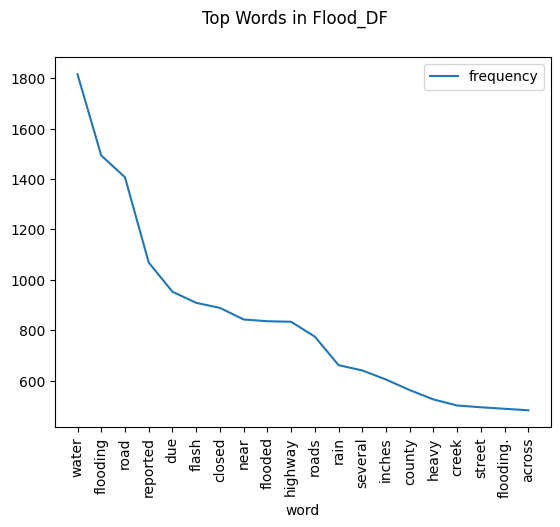

In [ ]:
# common words as a plot
# Frequency Distribution Plot
# look at first X words

# len(x) just the number of rows

x = x[0:20] # wanna play? change the 20 to 10 or 30 and see what happens...
            # you need to run the previous cell first
x.plot(x='word', y='frequency')
plt.xticks(np.arange(len(x)), x['word'], rotation=90)
plt.suptitle('Top Words in Flood_DF')
plt.show()


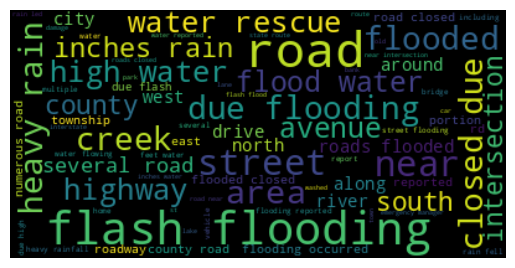

In [ ]:
# word cloud
# https://amueller.github.io/word_cloud/auto_examples/simple.html#sphx-glr-auto-examples-simple-py

from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(flood_df['EVENT_NARRATIVE'])) # just update the column name!

# # Display the generated image:
# # the matplotlib way:
# import matplotlib.pyplot as plt
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(' '.join(flood_df['EVENT_NARRATIVE'])) # just update the column name!
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [ ]:
# tokenizer
# make this a list with individual entries/values
flood_df['EVENT_NARRATIVE'] = flood_df.apply(lambda row: nltk.word_tokenize(row['EVENT_NARRATIVE']), axis=1)
flood_df.head()

<ipython-input-51-164ae793c27e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_df['EVENT_NARRATIVE'] = flood_df.apply(lambda row: nltk.word_tokenize(row['EVENT_NARRATIVE']), axis=1)


,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_AZIMUTH,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE
0,137295,824116,TEXAS,48,2019,May,Flash Flood,BEXAR,5/9/2019 15:54,CST-6,...,N,LEON SPGS,NNE,SAN GERONIMO,29.7898,-98.6406,29.7158,-98.7744,Thunderstorms developed along a cold front as ...,"[thunderstorms, produced, heavy, rain, led, fl..."
23,141709,850823,MISSOURI,29,2019,September,Flash Flood,VERNON,9/22/2019 18:11,CST-6,...,NE,NEVADA,N,NEVADA,37.8400,-94.3600,37.8386,-94.3695,Storms moved into southeast Kansas during the ...,"[local, roads, ,, city, streets, multiple, lan..."
85,139516,839377,OHIO,39,2019,June,Flash Flood,ASHLAND,6/17/2019 3:24,EST-5,...,N,POLK,SSW,POLK,40.9500,-82.2200,40.9388,-82.2251,A stationary front supported widespread shower...,"[redhaw, creek, polk, washed, portion, route, ..."
89,139524,839391,OHIO,39,2019,June,Flash Flood,MARION,6/19/2019 8:25,EST-5,...,N,PROSPECT,NNW,PROSPECT,40.4500,-83.1800,40.4578,-83.1829,An area of low pressure moved east along a sta...,"[localized, heavy, rain, moved, southern, mari..."
147,139891,841501,MISSISSIPPI,28,2019,August,Flash Flood,SIMPSON,8/26/2019 5:00,CST-6,...,W,D LO,W,D LO,31.9800,-89.9300,31.9803,-89.9043,A very moist airmass was in place across the r...,"[flash, flooding, occurred, highway, 540, w, p..."


In [ ]:
# stemming
flood_df['Stemmed'] = flood_df['EVENT_NARRATIVE'].apply(lambda x: [ps.stem(y) for y in x]) # Stem every word.
flood_df.head()

<ipython-input-52-626e4a32a0e4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_df['Stemmed'] = flood_df['EVENT_NARRATIVE'].apply(lambda x: [ps.stem(y) for y in x]) # Stem every word.


,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,Stemmed
0,137295,824116,TEXAS,48,2019,May,Flash Flood,BEXAR,5/9/2019 15:54,CST-6,...,LEON SPGS,NNE,SAN GERONIMO,29.7898,-98.6406,29.7158,-98.7744,Thunderstorms developed along a cold front as ...,"[thunderstorms, produced, heavy, rain, led, fl...","[thunderstorm, produc, heavi, rain, led, flash..."
23,141709,850823,MISSOURI,29,2019,September,Flash Flood,VERNON,9/22/2019 18:11,CST-6,...,NEVADA,N,NEVADA,37.8400,-94.3600,37.8386,-94.3695,Storms moved into southeast Kansas during the ...,"[local, roads, ,, city, streets, multiple, lan...","[local, road, ,, citi, street, multipl, lane, ..."
85,139516,839377,OHIO,39,2019,June,Flash Flood,ASHLAND,6/17/2019 3:24,EST-5,...,POLK,SSW,POLK,40.9500,-82.2200,40.9388,-82.2251,A stationary front supported widespread shower...,"[redhaw, creek, polk, washed, portion, route, ...","[redhaw, creek, polk, wash, portion, rout, 800..."
89,139524,839391,OHIO,39,2019,June,Flash Flood,MARION,6/19/2019 8:25,EST-5,...,PROSPECT,NNW,PROSPECT,40.4500,-83.1800,40.4578,-83.1829,An area of low pressure moved east along a sta...,"[localized, heavy, rain, moved, southern, mari...","[local, heavi, rain, move, southern, marion, c..."
147,139891,841501,MISSISSIPPI,28,2019,August,Flash Flood,SIMPSON,8/26/2019 5:00,CST-6,...,D LO,W,D LO,31.9800,-89.9300,31.9803,-89.9043,A very moist airmass was in place across the r...,"[flash, flooding, occurred, highway, 540, w, p...","[flash, flood, occur, highway, 540, w, past, j..."


In [ ]:
# clean up that crop damage column
# this is best
# hacked this example: https://stackoverflow.com/questions/39684548/convert-the-string-2-90k-to-2900-or-5-2m-to-5200000-in-pandas-dataframe
flood_df['DAMAGE_CROPS'] = (flood_df['DAMAGE_CROPS'].replace(r'[KM]+$', '', regex=True).astype(float) * \
              flood_df['DAMAGE_CROPS'].str.extract(r'[\d\.]+([KM]+)', expand=False)
                .fillna(1)
                .replace(['K','M'], [10**3, 10**6]).astype(int))
flood_df['DAMAGE_CROPS'].describe()

<ipython-input-53-316b18a52adc>:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .replace(['K','M'], [10**3, 10**6]).astype(int))
<ipython-input-53-316b18a52adc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  flood_df['DAMAGE_CROPS'] = (flood_df['DAMAGE_CROPS'].replace(r'[KM]+$', '', regex=True).astype(float) * \


,DAMAGE_CROPS
count,3.851000e+03
mean,3.013238e+04
std,4.924303e+05
min,0.000000e+00
25%,0.000000e+00
50%,0.000000e+00
75%,0.000000e+00
max,1.000000e+07


# Making a text classification algorithm
* Put the hail_df and flood_df together as one big dataset (they have similar numbers of observations)
* Decide on how to create features for modeling (Bag of Words vs. TF-IDF)
* Split the data into test or train partitions
* Fit a classification model!
* Check out the error metrics

Try doing this with EPISODE_NARRATIVE vs. stemmed EVENT_NARRATIVE we created. We get interesting results depending on what we choose.

### Merge the Data (tmpdf)...
Just appending the hail_df rows and flood_df rows.

In [ ]:
# first, just appened the datasets you made

print(hail_df.shape)
print(flood_df.shape)

tmpdf = pd.concat([hail_df, flood_df], ignore_index=True, axis=0)
print(tmpdf.shape)

(3783, 29)
(3851, 29)
(7634, 29)


In [ ]:
# check it out!
tmpdf.info()
tmpdf.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7634 entries, 0 to 7633
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   EPISODE_ID         7634 non-null   int64  
 1   EVENT_ID           7634 non-null   int64  
 2   STATE              7634 non-null   object 
 3   STATE_FIPS         7634 non-null   int64  
 4   YEAR               7634 non-null   int64  
 5   MONTH_NAME         7634 non-null   object 
 6   EVENT_TYPE         7634 non-null   object 
 7   CZ_NAME            7634 non-null   object 
 8   BEGIN_DATE_TIME    7634 non-null   object 
 9   CZ_TIMEZONE        7634 non-null   object 
 10  END_DATE_TIME      7634 non-null   object 
 11  INJURIES_DIRECT    7634 non-null   int64  
 12  INJURIES_INDIRECT  7634 non-null   int64  
 13  DEATHS_DIRECT      7634 non-null   int64  
 14  DEATHS_INDIRECT    7634 non-null   int64  
 15  DAMAGE_PROPERTY    6647 non-null   object 
 16  DAMAGE_CROPS       6713 

,EPISODE_ID,EVENT_ID,STATE,STATE_FIPS,YEAR,MONTH_NAME,EVENT_TYPE,CZ_NAME,BEGIN_DATE_TIME,CZ_TIMEZONE,...,BEGIN_LOCATION,END_AZIMUTH,END_LOCATION,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EPISODE_NARRATIVE,EVENT_NARRATIVE,Stemmed
0,141212,848333,VERMONT,50,2019,September,Hail,WINDSOR,9/4/2019 12:29,EST-5,...,LUDLOW,W,LUDLOW,43.40,-72.72,43.40,-72.72,A strong mid-level disturbance and cold front ...,"[quarter, size, hail, reported, okemo, ski, re...","[quarter, size, hail, report, okemo, ski, reso..."
1,139926,844159,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:37,MST-7,...,FROID,ENE,FROID,48.39,-104.26,48.39,-104.26,Plentiful surface moisture from the southeast ...,"[trained, spotter, reported, hail, size, quart...","[train, spotter, report, hail, size, quarter, ..."
2,139926,844160,MONTANA,30,2019,September,Hail,ROOSEVELT,9/2/2019 8:50,MST-7,...,FROID,ENE,FROID,48.39,-104.29,48.39,-104.29,Plentiful surface moisture from the southeast ...,"[public, reported, ,, via, social, media, ,, q...","[public, report, ,, via, social, media, ,, qua..."
3,139926,844158,MONTANA,30,2019,September,Hail,SHERIDAN,9/2/2019 7:27,MST-7,...,PLENTYWOOD,WSW,PLENTYWOOD,48.72,-104.74,48.72,-104.74,Plentiful surface moisture from the southeast ...,"[public, reported, quarter, size, hail, .]","[public, report, quarter, size, hail, .]"
4,141962,852318,CONNECTICUT,9,2019,September,Hail,HARTFORD,9/4/2019 16:10,EST-5,...,ENFIELD,N,ENFIELD,41.97,-72.57,41.97,-72.57,A cold front pushed through southern New Engla...,"[dime, size, hail, reported, enfield, .]","[dime, size, hail, report, enfield, .]"


### Clean up the stemmed column into something useable for modeling
Let's get rid of the square brackets and leave it as a regular, cleaned up text column.

In [ ]:
# here's what it looked like before
tmpdf['Stemmed'].head()

,Stemmed
0,"[quarter, size, hail, report, okemo, ski, reso..."
1,"[train, spotter, report, hail, size, quarter, ..."
2,"[public, report, ,, via, social, media, ,, qua..."
3,"[public, report, quarter, size, hail, .]"
4,"[dime, size, hail, report, enfield, .]"


In [ ]:
# link: https://pythonhealthcare.org/2018/12/14/101-pre-processing-data-tokenization-stemming-and-removal-of-stop-words/
# try to change
def rejoin_words(row):
    my_list = row['Stemmed']
    joined_words = ( " ".join(my_list))
    return joined_words

tmpdf['Stemmed'] = tmpdf.apply(rejoin_words, axis=1)
# here it is after - no square brackets and commas!
tmpdf['Stemmed'].head()

,Stemmed
0,quarter size hail report okemo ski resort .
1,"train spotter report hail size quarter , along..."
2,"public report , via social media , quarter siz..."
3,public report quarter size hail .
4,dime size hail report enfield .


### Choose X and Y
This is where you can choose to either use 'Stemmed' or the raw 'EPISODE_NARRATIVE'. We will use 'Stemmed' as the first example - you will use the raw 'EPISODE_NARRATIVE' for your homework.

Both are 100% valid approaches to modeling - one just has a little more pre-processing.

In [ ]:
# split into X and Y
X=pd.DataFrame(tmpdf['Stemmed'])
y=tmpdf['EVENT_TYPE']
print(X.shape,y.shape)

(7634, 1) (7634,)


In [ ]:
# BTW - if you haven't already, you can mount your drive
# and save a copy of this data if you want

In [ ]:
# on your own, you should split into train and test
# and then use fit_transform(train) and transform(test)

## Create features for modeling: Bag of Words
This will tell you how many times each word was mentioned in a sample.

**Check out the documentation:** https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

[Unigram, bigram, trigram](https://www.google.com/url?sa=i&url=https%3A%2F%2Farshadmehmood.com%2Fdevelopment%2Fgenerate-unigrams-bigrams-trigrams-ngrams-etc-in-python%2F&psig=AOvVaw2DPfI9oyB65ONqb7AEDzM6&ust=1592425067747000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCJChmOeTh-oCFQAAAAAdAAAAABAD) is something you should be comfortable with.


* https://arshadmehmood.com/development/generate-unigrams-bigrams-trigrams-ngrams-etc-in-python/

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

# get rid of garbage text
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

#tokenizer to remove unwanted elements from out data like symbols and numbers
# IN ONE LINE OF CODE! Let's go for the more detailed description...
cv = CountVectorizer(lowercase=True,
                     stop_words='english',
                     ngram_range = (1,1), # (1,1) is unigram, (1,2) is uni and bigram, (2,2) is just bigram
                     tokenizer = token.tokenize)
text_counts= cv.fit_transform(X['Stemmed']) # don't forget to update this name, based on what you use!
print(text_counts.shape)

(7634, 7497)


/usr/local/lib/python3.11/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
6620 # unigrams
31570 # bigrams
48161 # trigrams
6620 + 31570+48161

86351

In [ ]:
# inspect text_counts
# check out the first row
print(text_counts)
np.sum(text_counts[1]) # see how many entries there are

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 85532 stored elements and shape (7634, 7497)>
  Coords	Values
  (0, 5681)	1
  (0, 6300)	1
  (0, 3463)	1
  (0, 5822)	1
  (0, 5126)	1
  (0, 6303)	1
  (0, 5834)	1
  (1, 5681)	1
  (1, 6300)	1
  (1, 3463)	1
  (1, 5822)	1
  (1, 6854)	1
  (1, 6426)	1
  (1, 3583)	1
  (1, 5715)	1
  (1, 6462)	1
  (1, 7174)	1
  (1, 7453)	1
  (2, 5681)	1
  (2, 6300)	1
  (2, 3463)	1
  (2, 5822)	1
  (2, 5646)	1
  (2, 6354)	1
  (2, 4664)	1
  :	:
  (7632, 6379)	1
  (7632, 6474)	1
  (7632, 5068)	1
  (7632, 2981)	1
  (7632, 648)	1
  (7632, 2530)	1
  (7633, 3583)	1
  (7633, 5715)	1
  (7633, 7174)	1
  (7633, 4943)	3
  (7633, 5896)	2
  (7633, 5095)	1
  (7633, 2877)	1
  (7633, 1605)	1
  (7633, 2339)	1
  (7633, 1892)	1
  (7633, 3044)	1
  (7633, 2981)	1
  (7633, 2085)	1
  (7633, 3030)	1
  (7633, 3059)	1
  (7633, 5996)	1
  (7633, 5560)	2
  (7633, 2565)	2
  (7633, 4605)	1


np.int64(11)

## Build a model

In [ ]:
from sklearn.model_selection import train_test_split

# 60% Training; 20% Validation; 20% Test
# text_counts is a SPARSE MATRIX!
# notice we we
X_train, X_test, y_train, y_test = train_test_split(text_counts, y, test_size=0.4)

X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.5)

In [ ]:
print(X_train.shape, X_val.shape, X_test.shape)
# voila! note how there are 6620 unigrams (unique words)
# if you use bigrams (1,2) this will get bigger

(4580, 7497) (2290, 7497) (2290, 7497)


In [ ]:
from sklearn.tree import DecisionTreeClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = DecisionTreeClassifier().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("DTC Accuracy:",metrics.accuracy_score(y_test, predicted))
predicted= clf.predict(X_val)
print("DTC Accuracy:",metrics.accuracy_score(y_val, predicted))

# WOW! 99% accuracy on test data.

# think of how much time this saves and we didn't even have
# to read any of this, just needed to be careful with our
# data prep and let it rip!

DTC Accuracy: 1.0
DTC Accuracy: 1.0


In [ ]:
from sklearn.ensemble import RandomForestClassifier
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = RandomForestClassifier().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("RFC Accuracy:",metrics.accuracy_score(y_test, predicted))

# WOW! 99% accuracy - even better!

# think of how much time this saves and we didn't even have
# to read any of this, just needed to be careful with our
# data prep and let it rip!

RFC Accuracy: 1.0


In [ ]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

 Flash Flood       1.00      1.00      1.00      1128
        Hail       1.00      1.00      1.00      1162

    accuracy                           1.00      2290
   macro avg       1.00      1.00      1.00      2290
weighted avg       1.00      1.00      1.00      2290



In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, predicted) # only a handful of misses here, wow...

array([[1128,    0],
       [   0, 1162]])

# Create features for modeling: TF-IDF
This is a more sophisticated method. TF-IDF is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

**Make sure you are comfortable with this:** https://qph.fs.quoracdn.net/main-qimg-316793eea38e7acdcc0cd2224bcaf6b8

![alt text](https://qph.fs.quoracdn.net/main-qimg-316793eea38e7acdcc0cd2224bcaf6b8)

* TF(w) = (Number of times term w appears in a document) / (Total number of terms in the document)
* IDF(w) = log_e(Total number of documents / Number of documents with term w in it)
*TF-IDF (term frequency * inverse document frequency) is the product of these two quantities - that's it!

**From DataCamp:** In Term Frequency(TF), you just count the number of words occurred in each document. The main issue with this Term Frequency is that it will give more weight to longer documents. Term frequency is basically the output of the Bag of Words (BoW) model.

IDF(Inverse Document Frequency) measures the amount of information a given word provides across the document. IDF is the logarithmically scaled inverse ratio of the number of documents that contain the word and the total number of documents.

TF-IDF(Term Frequency-Inverse Document Frequency) normalizes the document term matrix. It is the product of TF and IDF. Word with high tf-idf in a document, it is most of the times occurred in given documents and must be absent in the other documents. So the words must be a signature word.

In [ ]:
# create the matrix
from sklearn.feature_extraction.text import TfidfVectorizer
tf=TfidfVectorizer()
text_tf= tf.fit_transform(X['Stemmed']) # don't forget to update!!!

In [ ]:
# check out what you did
text_tf.shape # there are 6695 TF-IDF

(7634, 7591)

In [ ]:
# notice there are 7 words here - it is the index corresponding to the word, followed by TF-IDF!
print(text_tf[0])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 7 stored elements and shape (1, 7591)>
  Coords	Values
  (0, 5740)	0.17424014936219637
  (0, 6365)	0.1339657770700636
  (0, 3496)	0.11365209013006905
  (0, 5883)	0.10960788616357636
  (0, 5177)	0.5807948594324737
  (0, 6368)	0.5807948594324737
  (0, 5895)	0.5021130521483176


In [ ]:
# split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text_tf, y,
                                                    test_size=0.3, random_state=123)

In [ ]:
# fit a model
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
# Model Generation Using Multinomial Naive Bayes
clf = DecisionTreeClassifier().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("DTC Accuracy:",metrics.accuracy_score(y_test, predicted))

# 98%!

DTC Accuracy: 0.9908336970755128


In [ ]:
# fit a model
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
# Model Generation Using RFC
clf = RandomForestClassifier().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("RFC Accuracy:",metrics.accuracy_score(y_test, predicted))

# 99%! Your results might be a little different

RFC Accuracy: 0.9973810563072893


# Thoughts
TF-IDF is interesting - and it is essentially a glorified form of feature engineering.

We can use more condensed code to fit the TF_IDF with a feedforward neural network.
**Link:** https://www.kaggle.com/welgum/tf-idf-with-simple-nn-keras

Later on, we can consider (1) one-hot encoding for use in a neural network or (2) learn word embeddings which we can either flatten or incorporate into the LSTM and (3) import pre-learned word embeddings for help 'hot-rod' our models.

In [ ]:
# we can start this in another notebook